In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [2]:
#Limiting data to that of the last 6 months.
from datetime import datetime
from dateutil.relativedelta import relativedelta
import calendar

now = datetime.today()
six_months = datetime.today() + relativedelta(months=-6, days = -3)

def convert(date):
    return str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

def convert_2(date):
    return datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')

def convert_3(date):
    return datetime.utcfromtimestamp(date).strftime('%Y-%m-%d')

In [3]:
#Defining functions.
import requests
import io
import json

def coinmetrics(csv_name, start = six_months, end = now):
    
    time = (end - start).days

    url = 'https://coinmetrics.io/data/' + csv_name + '.csv'
    request = requests.get(url)
    
    coin = pd.read_csv(io.StringIO(request.text))[-time:]
    coin = coin[['date', 'txCount', 'marketcap(USD)', 'price(USD)', 'exchangeVolume(USD)']]
    coin.columns = ['Date', 'Transactions', 'Market Cap', 'Price', 'Exchange Volume']
    coin['Price Change'] = coin['Price'].pct_change()*100
    coin.reset_index(inplace = True, drop = True)
    
    return coin

def coinmarketcap(coin_name, start = six_months, end = now):
    
    start, end = convert(start), convert(end)
    
    coin = pd.read_html('https://coinmarketcap.com/currencies/' + coin_name + '/historical-data/?start=' + start
                        + '&end=' + end)[0]
    coin['Date'] = coin['Date'].apply(convert_2)
    coin = coin[['Date', 'Open*', 'Volume', 'Market Cap']]
    coin.columns = ['Date', 'Price', 'Exchange Volume', 'Market Cap']
    
    coin['Price'] = pd.to_numeric(coin['Price'], errors = 'coerce')
    coin['Exchange Volume'] = pd.to_numeric(coin['Exchange Volume'], errors = 'coerce')
    coin['Market Cap'] = pd.to_numeric(coin['Market Cap'], errors = 'coerce')

    coin = coin.iloc[::-1]
    coin['Price Change'] = coin['Price'].pct_change()*100
    
    return coin

def subreddit(subreddit_name, start = six_months, end = now):
    
    time = (end - start).days
    time_str = str(time + 1)
    
    sub = requests.get('https://api.pushshift.io/reddit/submission/search/?after=' + time_str +
                           'd&subreddit=' + subreddit_name + '&aggs=created_utc&frequency=d&size=0')
    sub_json = sub.json()
    submissions = pd.DataFrame(sub_json['aggs']['created_utc'])
    submissions.columns = ['Submissions', 'UTC']

    com = requests.get('https://api.pushshift.io/reddit/comment/search/?after=' + time_str +
                           'd&subreddit=' + subreddit_name + '&aggs=created_utc&frequency=d&size=0')
    com_json = com.json()
    comments = pd.DataFrame(com_json['aggs']['created_utc'])
    comments.columns = ['Comments', 'UTC']

    subreddit = submissions.merge(comments, on = 'UTC')
    subreddit['Date'] = subreddit['UTC'].apply(convert_3)

    return subreddit

def merged_coin(site_sub, subreddit_name, site_name = 'coinmetrics', start = six_months, end = now):

    if site_name == 'coinmetrics':
        coin = coinmetrics(site_sub, start, end)
    elif site_name == 'coinmarketcap':
        coin = coinmarketcap(site_sub, start, end)
        
    sub = subreddit(subreddit_name, start, end)
    coin = coin.merge(sub, on = 'Date')
    
    coin.drop('UTC', axis = 1, inplace = True)
    coin.dropna(inplace = True)
    coin.reset_index(inplace = True, drop = True)
    
    return coin

def correlation(site_sub, subreddit_name, site_name = 'coinmetrics', start = six_months, end = now,
                corr_type = 'pearson'):
    
    coin = merged_coin(site_sub, subreddit_name, site_name, start, end)
    sns.pairplot(coin)
    plt.show()
    
    return coin.corr(method = corr_type) #Change type of correlation here.

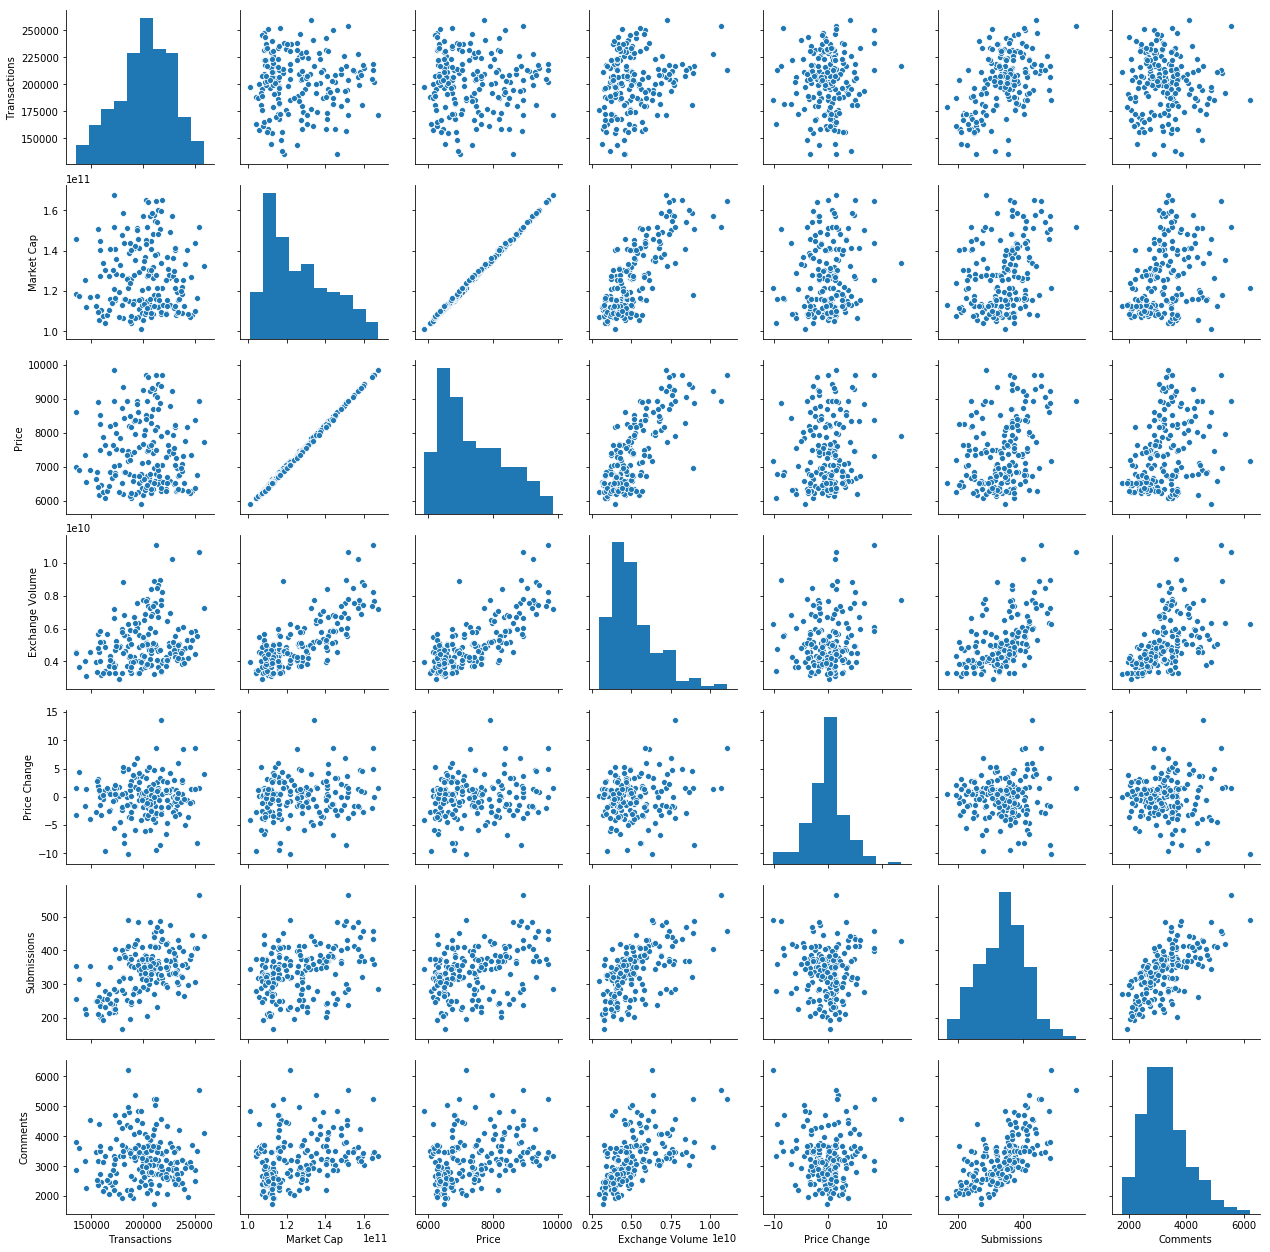

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,-0.000488,-0.020386,0.216673,0.059569,0.499627,-0.028826
Market Cap,-0.000488,1.000000,0.999374,0.766346,0.143451,0.328885,0.288493
Price,-0.020386,0.999374,1.000000,0.770948,0.141001,0.336202,0.309569
Exchange Volume,0.216673,0.766346,0.770948,1.000000,0.151107,0.579652,0.533441
Price Change,0.059569,0.143451,0.141001,0.151107,1.000000,0.007533,-0.025651
Submissions,0.499627,0.328885,0.336202,0.579652,0.007533,1.000000,0.661799
Comments,-0.028826,0.288493,0.309569,0.533441,-0.025651,0.661799,1.000000


In [4]:
#Bitcoin
correlation('btc', 'bitcoin')

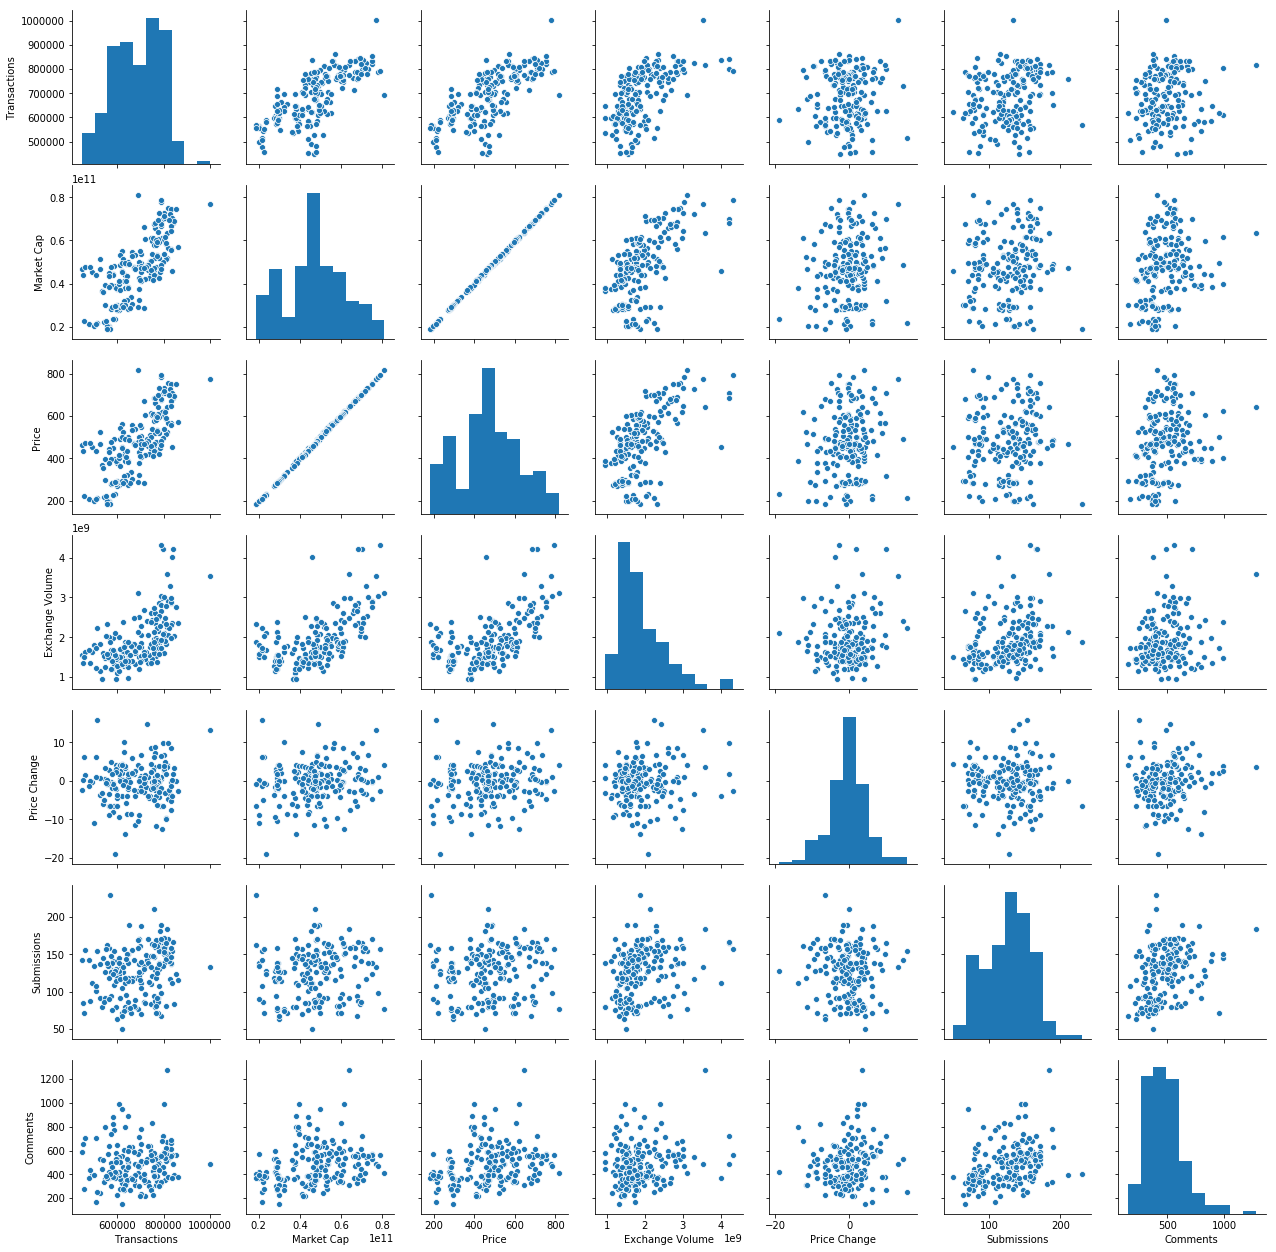

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.728654,0.724654,0.603458,0.076561,0.223885,0.082204
Market Cap,0.728654,1.000000,0.999729,0.603838,0.155381,0.084491,0.244352
Price,0.724654,0.999729,1.000000,0.603126,0.155727,0.084141,0.253825
Exchange Volume,0.603458,0.603838,0.603126,1.000000,0.095974,0.274234,0.196548
Price Change,0.076561,0.155381,0.155727,0.095974,1.000000,-0.039323,0.073682
Submissions,0.223885,0.084491,0.084141,0.274234,-0.039323,1.000000,0.305630
Comments,0.082204,0.244352,0.253825,0.196548,0.073682,0.305630,1.000000


In [5]:
#Ethereum
correlation('eth', 'ethereum')

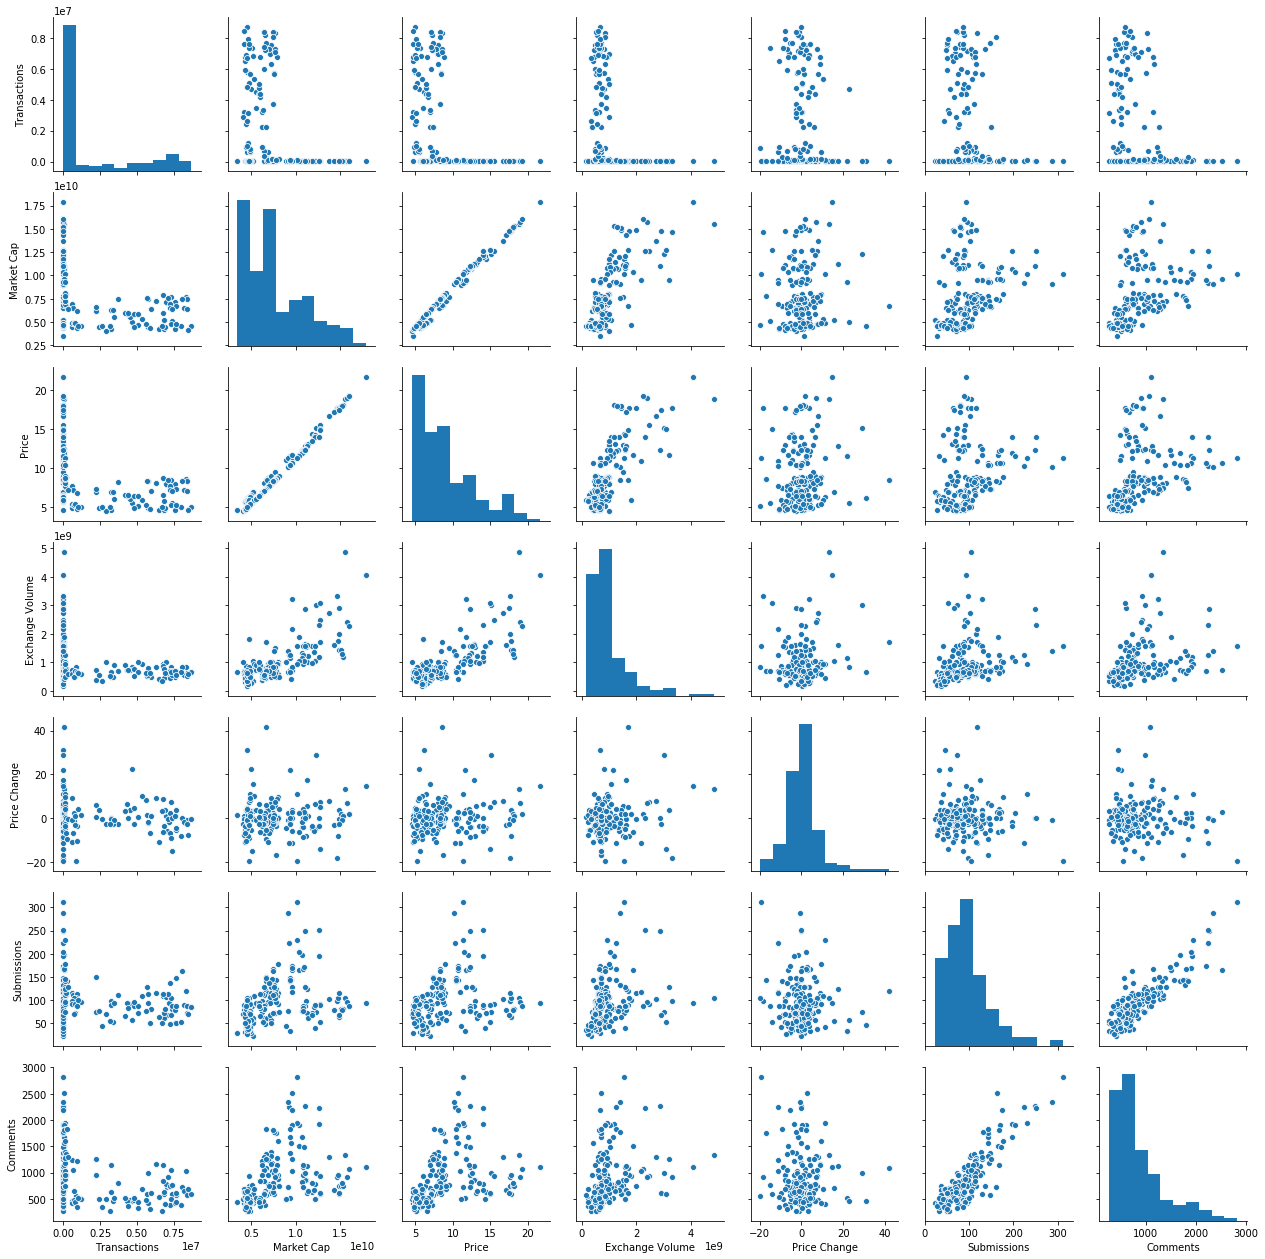

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,-0.393267,-0.438012,-0.309013,-0.069877,-0.107896,-0.321339
Market Cap,-0.393267,1.000000,0.992835,0.746941,0.049061,0.330455,0.412383
Price,-0.438012,0.992835,1.000000,0.761888,0.076807,0.258456,0.364529
Exchange Volume,-0.309013,0.746941,0.761888,1.000000,0.135936,0.260397,0.310678
Price Change,-0.069877,0.049061,0.076807,0.135936,1.000000,-0.089373,-0.074544
Submissions,-0.107896,0.330455,0.258456,0.260397,-0.089373,1.000000,0.861619
Comments,-0.321339,0.412383,0.364529,0.310678,-0.074544,0.861619,1.000000


In [6]:
#EOS
correlation('eos', 'eos')

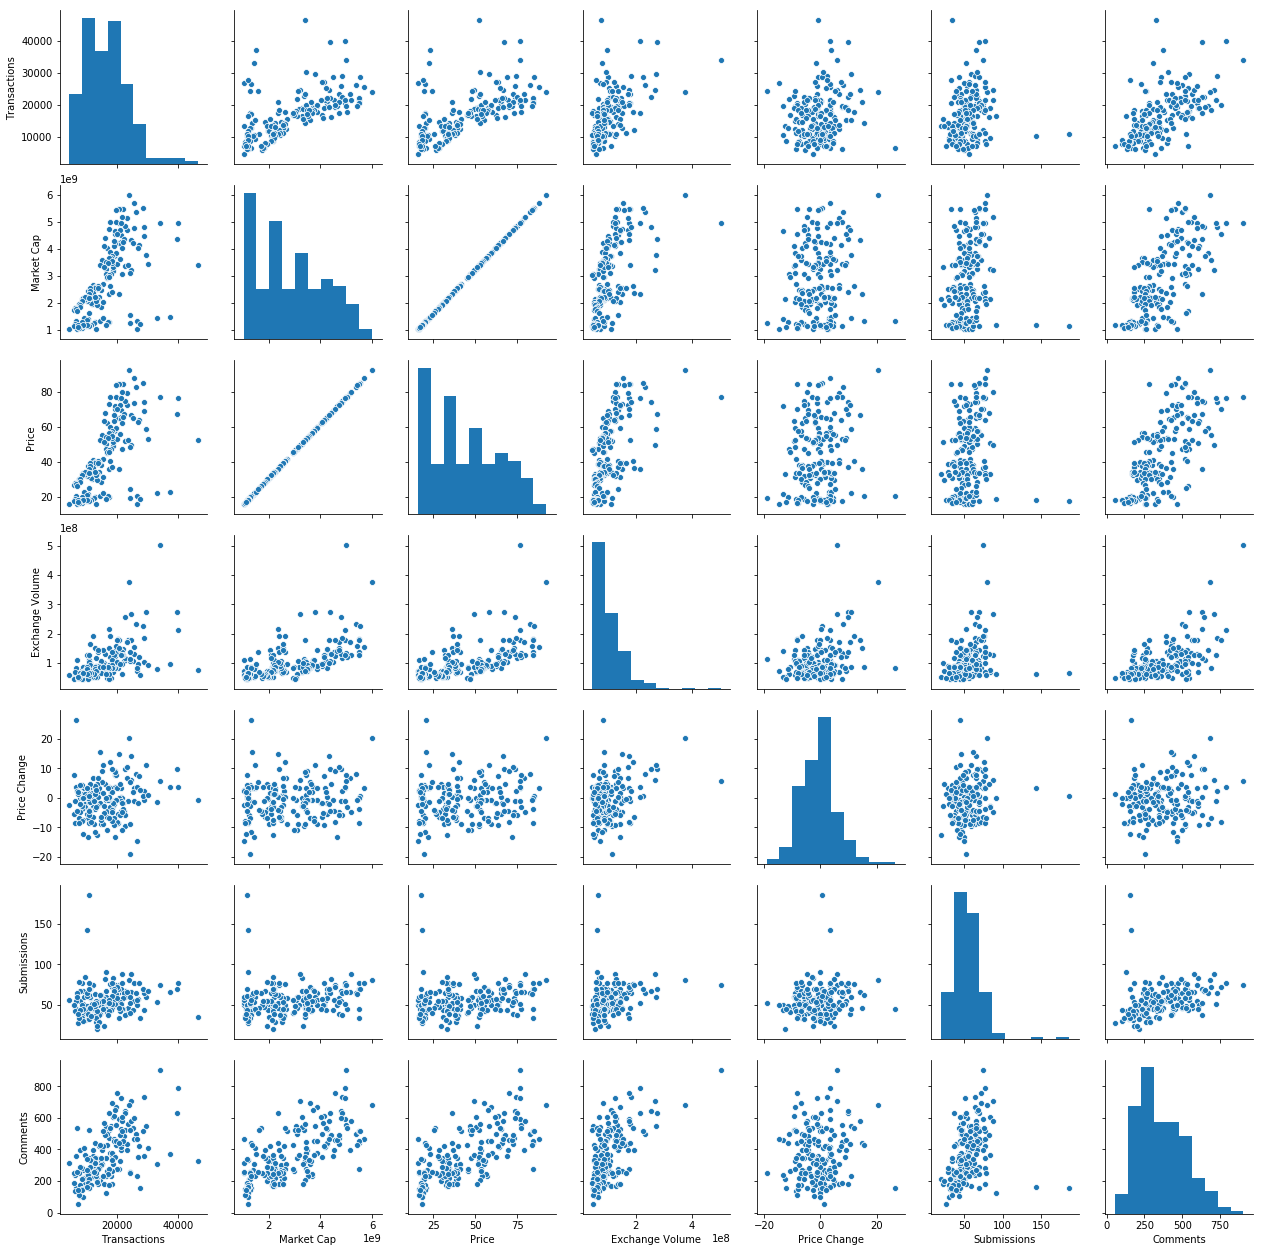

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.619629,0.619638,0.549471,0.149281,0.150512,0.589551
Market Cap,0.619629,1.000000,1.000000,0.598966,0.116348,0.188902,0.687711
Price,0.619638,1.000000,1.000000,0.598968,0.116357,0.188881,0.687708
Exchange Volume,0.549471,0.598966,0.598968,1.000000,0.325510,0.279298,0.610098
Price Change,0.149281,0.116348,0.116357,0.325510,1.000000,0.129438,0.070717
Submissions,0.150512,0.188902,0.188881,0.279298,0.129438,1.000000,0.303065
Comments,0.589551,0.687711,0.687708,0.610098,0.070717,0.303065,1.000000


In [7]:
#NEO
correlation('neo', 'neo')

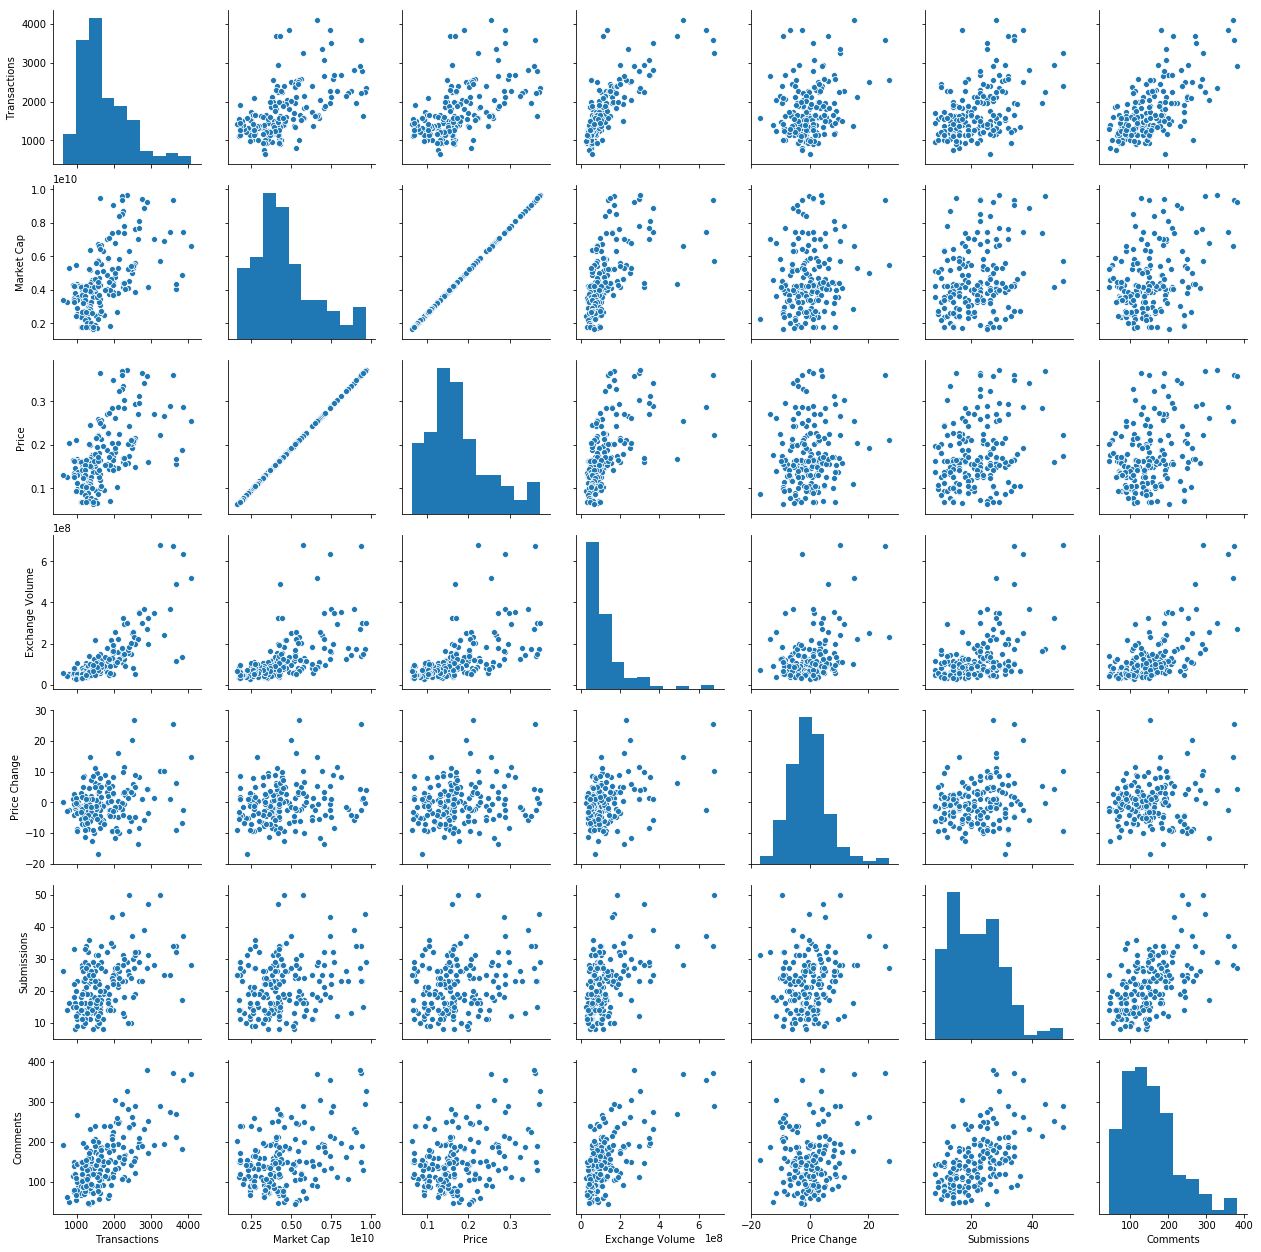

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.564627,0.564627,0.800525,0.245682,0.460057,0.649106
Market Cap,0.564627,1.000000,1.000000,0.575554,0.150482,0.239308,0.382855
Price,0.564627,1.000000,1.000000,0.575554,0.150482,0.239308,0.382855
Exchange Volume,0.800525,0.575554,0.575554,1.000000,0.371167,0.508843,0.640697
Price Change,0.245682,0.150482,0.150482,0.371167,1.000000,0.165161,0.169848
Submissions,0.460057,0.239308,0.239308,0.508843,0.165161,1.000000,0.540016
Comments,0.649106,0.382855,0.382855,0.640697,0.169848,0.540016,1.000000


In [8]:
#ADA
correlation('ada', 'cardano')

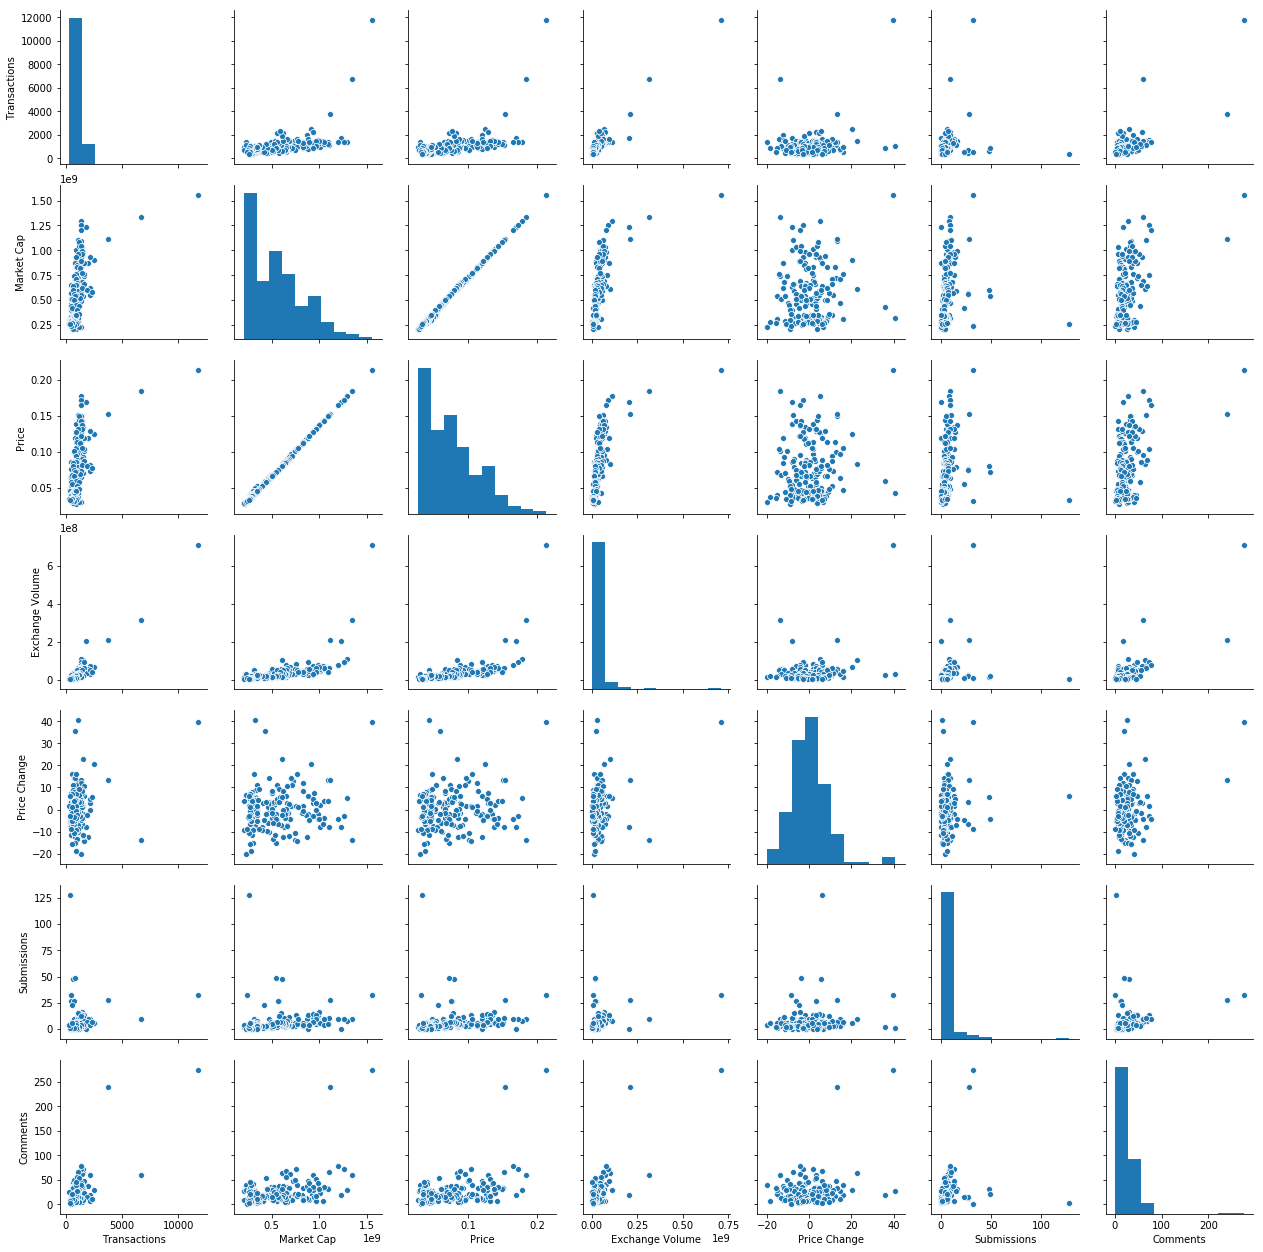

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.558377,0.556052,0.943237,0.261700,0.153276,0.726486
Market Cap,0.558377,1.000000,0.998491,0.605129,0.105982,0.118629,0.450788
Price,0.556052,0.998491,1.000000,0.608684,0.110337,0.114393,0.456902
Exchange Volume,0.943237,0.605129,0.608684,1.000000,0.292597,0.173694,0.772792
Price Change,0.261700,0.105982,0.110337,0.292597,1.000000,0.103433,0.303309
Submissions,0.153276,0.118629,0.114393,0.173694,0.103433,1.000000,0.190428
Comments,0.726486,0.450788,0.456902,0.772792,0.303309,0.190428,1.000000


In [9]:
#Zilliqa
correlation('zil', 'zilliqa')

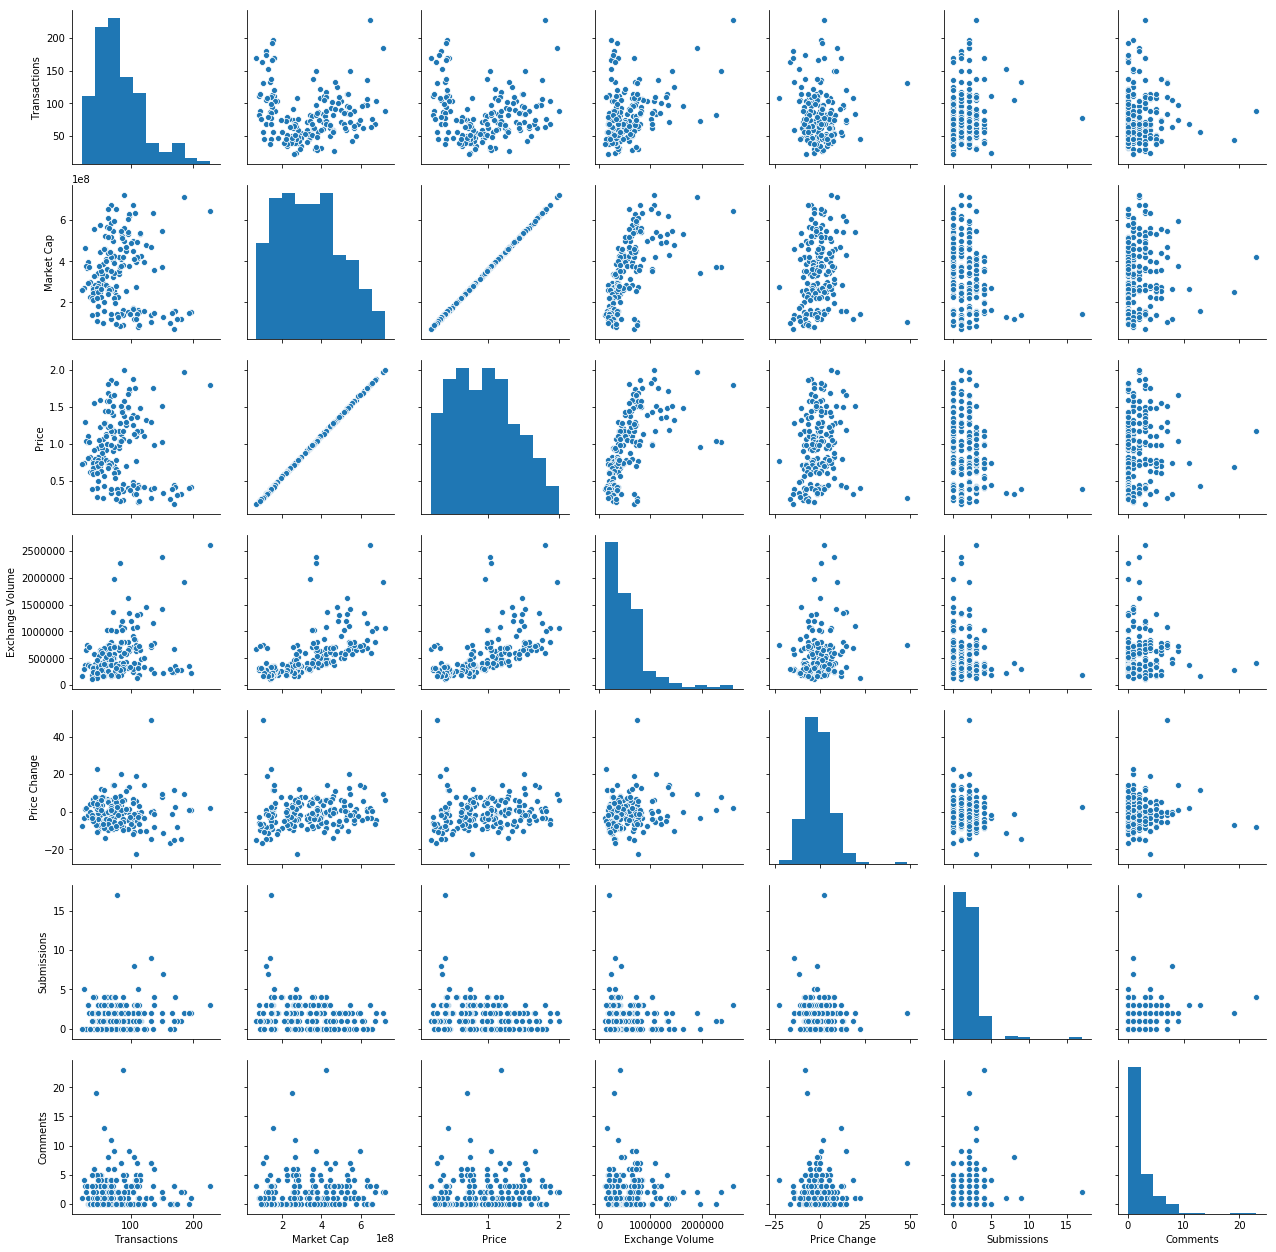

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,-0.020537,-0.023592,0.340211,-0.005507,0.074865,-0.018735
Market Cap,-0.020537,1.000000,0.999922,0.594897,0.137676,-0.271851,0.028685
Price,-0.023592,0.999922,1.000000,0.593721,0.136747,-0.271658,0.030216
Exchange Volume,0.340211,0.594897,0.593721,1.000000,0.162441,-0.181480,-0.005445
Price Change,-0.005507,0.137676,0.136747,0.162441,1.000000,-0.090351,0.044926
Submissions,0.074865,-0.271851,-0.271658,-0.181480,-0.090351,1.000000,0.158274
Comments,-0.018735,0.028685,0.030216,-0.005445,0.044926,0.158274,1.000000


In [10]:
#RChain
correlation('rhoc', 'RChain')

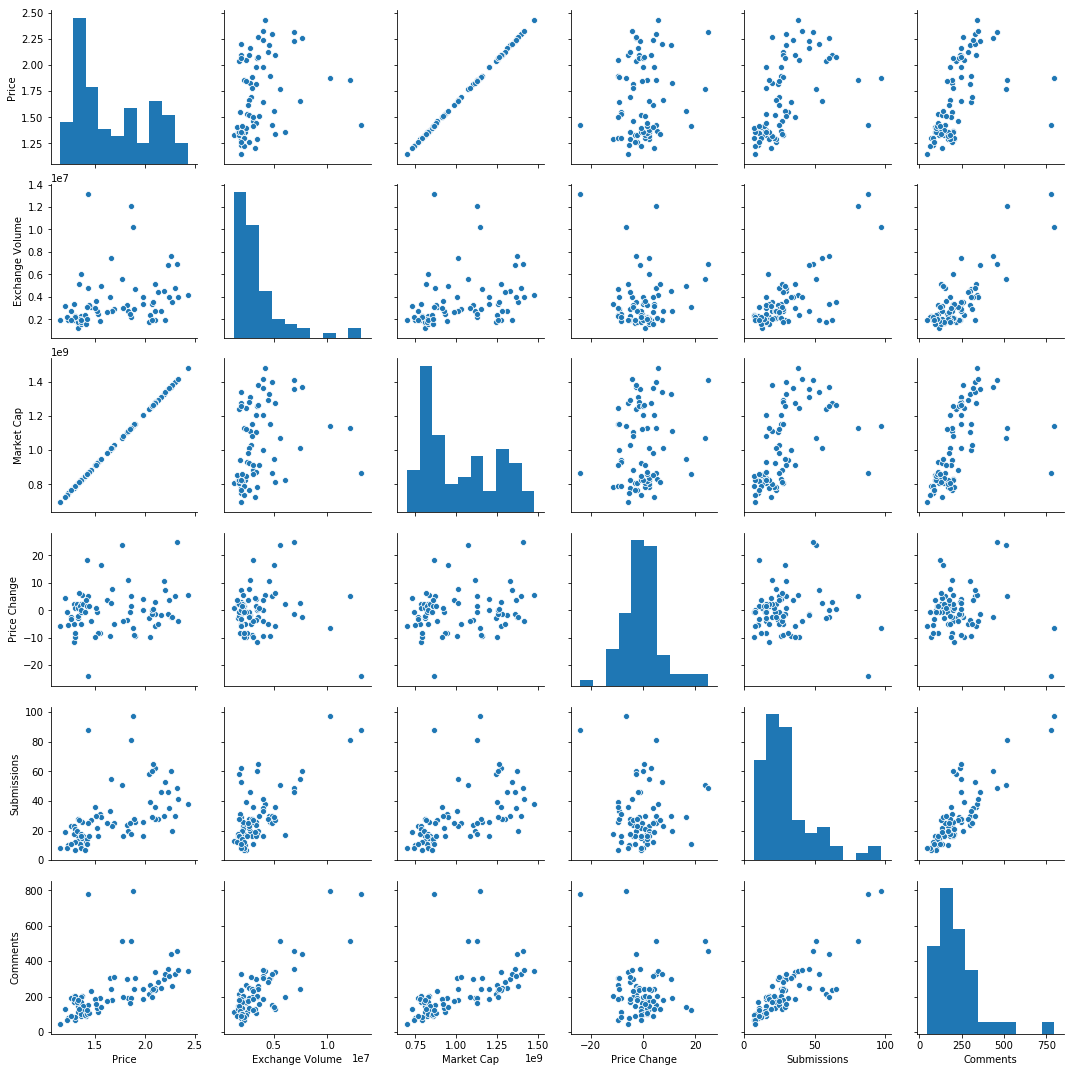

,Price,Exchange Volume,Market Cap,Price Change,Submissions,Comments
Price,1.000000,0.306553,0.999973,0.163283,0.539290,0.536941
Exchange Volume,0.306553,1.000000,0.305759,-0.007362,0.720232,0.810520
Market Cap,0.999973,0.305759,1.000000,0.163420,0.538035,0.535740
Price Change,0.163283,-0.007362,0.163420,1.000000,-0.021558,-0.050877
Submissions,0.539290,0.720232,0.538035,-0.021558,1.000000,0.832498
Comments,0.536941,0.810520,0.535740,-0.050877,0.832498,1.000000


In [11]:
#Tezos
correlation('tezos', 'tezos', 'coinmarketcap')